In [127]:
# Modules to import
import ast
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload

In [111]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

### IV.4 Character Study for Cultural Influence Analysis

In [112]:
from scriptculture import process_data_character          # Import the function that processes the data for this study

df_character_influence = process_data_character()
df_character_influence.head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
0,'Baby' Louise,/m/0c0lv89,Diane Pace,Gypsy,1962-01-01,[United States of America],[United States of America],1
1,ACP Jai Dixit,/m/0220_c2,Abhishek Bachchan,Dhoom,2004-08-27,[India],[India],1
2,Abigail Chase,/m/0k14v6,Diane Kruger,National Treasure,2004-11-08,[United States of America],[United States of America],1
3,Abraham Lincoln,/m/0k89pf,Henry Fonda,Young Mr. Lincoln,1939-01-01,[United States of America],[United States of America],1
4,Abraham Van Helsing,/m/0jxjsg,Edward Van Sloan,Dracula,1931-02-12,[United States of America],"[Spain, France, United States of America, Unit...",4


In [113]:
df_character_influence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Character                    970 non-null    object
 1   character_actor_freebase_id  970 non-null    object
 2   actor_name                   970 non-null    object
 3   first_movie_name             970 non-null    object
 4   first_apperance_date         969 non-null    object
 5   origin_country               970 non-null    object
 6   all_countries                970 non-null    object
 7   number_countries             970 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 60.8+ KB


For this analysis, we grouped the characters that appeared in different countries (from the character_cluster database). 

The processed dataset that we'll use for this analyse is completed with the features :
 - first_movie_name : The first movie in which the character appeared
 - first_apperance_date : The date of release of the first movie 
 - origin_country : The country of the first movie
 - all_countries : the countries of origin of all the movies in which the character has appeared 
 - number_countries : count of all_countries


In [114]:
df_character_influence.describe()

,number_countries
count,970.000000
mean,1.797938
std,1.161116
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


970 characters appear in multiple films; on average, they appear in 1.8 different countries. They feature in up to 8 different films. Let's look at the distribution of the number of countries

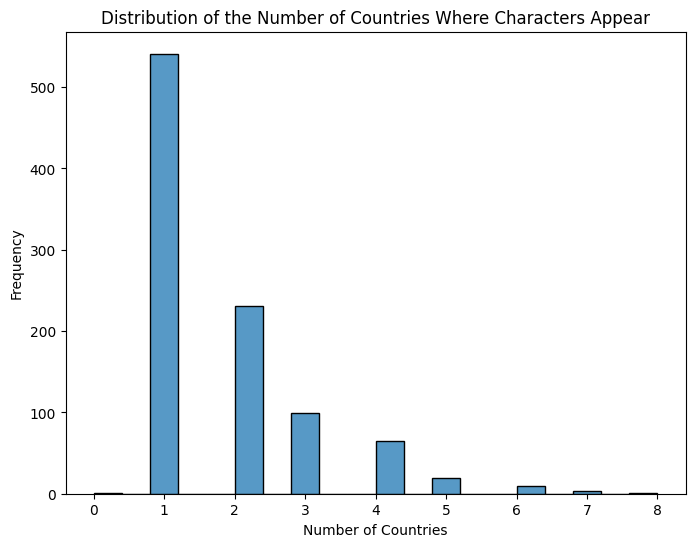

In [115]:
plt.figure(figsize=(8, 6))
sns.histplot(df_character_influence['number_countries'], kde=False, bins=20)

plt.title('Distribution of the Number of Countries Where Characters Appear')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.show()

In [116]:
print(df_character_influence[df_character_influence['number_countries'] > 1].count()) #Number of characters that appear in more than one country
print("number of influence point to be given :",df_character_influence['number_countries'].sum()-970) #Number of influence point to be given

Character                      428
character_actor_freebase_id    428
actor_name                     428
first_movie_name               428
first_apperance_date           428
origin_country                 428
all_countries                  428
number_countries               428
dtype: int64
number of influence point to be given : 774


Of the 970 characters, 428 appear in movies produced across different countries, which is not a large sample. We will keep this in mind as we test the significance of our study.

For each character appearing in a movie produced by a different country, we will assign 1 influence point to the character's origin country. This results in a total of 774 points being assigned.

A major concern that remains is whether the method of taking the first movie appearance as the origin country of a character is reliable.

Let's test this with the character that appears in movies produced in the most countries.

In [11]:
#find the character that appear in 8 countries and show all the origin countries one by one

df_character_influence[df_character_influence['number_countries'] == 8].head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Australia, Spain, Germany, Austria, France, P...",8


The character appearing in productions from the most different countries is Cardinal Richelieu (French origin). However, with our initial method, the influence points would not have been distributed to France but to UK, US and Spain.

This analysis drives us to explore other methods for identifying character origins. One possibility is to leverage Natural Language Processing (NLP) models, such as spaCy to analyze movie summaries geographical terms and better determine the character's origin. 

Additionally, using embedding models like Hugging Face transformers could help identify implicit relationships within the movie summaries and find where the history of the movie take place and deduct the characters origin from this.

In [12]:
from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
character = "Maria Elena"

# Here we define the label (countries in our case)
labels = ["United States", "France", "India", "Germany","United Kingdom","Italy","Spain","China","Scotland"]

result = nlp(character, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head()

c:\Users\Oscar\anaconda3\envs\projet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Label,Score
0,Spain,0.390203
1,Italy,0.147756
2,United Kingdom,0.085401
3,United States,0.078174
4,India,0.068733


On peut carrément trouver l'origine du personnage avec ça. ça marche vraiment bien !

In [ ]:
from countries import europe, north_america, south_america, africa, east_asia, south_asia, middle_east, eastern_europe_central_asia, oceania, caribbean



from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
character = "Maria Elena"

# Here we define the label (countries in our case)
labels = (
    list(europe) +
    list(north_america) +
    list(south_america) +
    list(africa) +
    list(east_asia) +
    list(south_asia) +
    list(middle_east) +
    list(eastern_europe_central_asia) +
    list(oceania) +
    list(caribbean)
)


result = nlp(character, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head(10)

In [117]:
df_character_nlp = pd.read_csv('character_countries.csv')
df_character_influence_nlp = pd.merge(df_character_influence, df_character_nlp, on='Character', how='inner')

In [118]:
df_character_influence_nlp['number_other_countries']=df_character_influence_nlp['number_countries']-1

In [119]:
df_character_influence_nlp.sample(10)

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries,Best_Country,Best_Score,number_other_countries
308,Gabriel Martin,/m/045x5sk,Heath Ledger,The Patriot,2000-06-27,"[United States of America, Germany]","[Germany, United States of America]",2,Germany,0.542762,1
681,Pat Chambers,/m/02vc39t,Preston Foster,"I, the Jury",1953-07-29,[United States of America],[United States of America],1,United States of America,0.089966,0
388,Jack Foley,/m/04djr3v,Chris O'Donnell,Circle of Friends,1995-03-15,"[United States of America, Ireland, United Kin...","[Ireland, United States of America, United Kin...",3,United States of America,0.534324,2
699,Police Inspector,/m/0h7187r,Janagaraj,Apoorva Sagodharargal,1989-04-14,[India],"[India, United Kingdom]",2,United Kingdom,0.651641,1
689,Perry Smith,/m/0jzvdm,Robert Blake,In Cold Blood,1967-01-01,[United States of America],"[Canada, United States of America]",2,United States of America,0.636024,1
633,Mr. George Wilson,/m/02vbzpl,Walter Matthau,Dennis the Menace,1993-06-24,[United States of America],[United States of America],1,United States of America,0.076602,0
860,Taylor McKessie,/m/0jzdzk,Monique Coleman,High School Musical,2006-01-20,[United States of America],[United States of America],1,United States of America,0.077723,0
545,Lucy Pevensie,/m/02vcr1y,Jayma Mays,Epic Movie,2007-01-25,[United States of America],"[Poland, Czech Republic, United Kingdom, Unite...",5,United Kingdom,0.711971,4
701,Pooja Malhotra,/m/040jw9x,Ayesha Jhulka,Rang,1993-07-09,[India],[India],1,India,0.450880,0
21,Alfred Pennyworth,/m/0497wl1,Michael Gough,Batman & Robin,1997-06-12,"[United States of America, United Kingdom]","[United States of America, United Kingdom]",2,United Kingdom,0.664201,1


In [16]:
df_character_influence_nlp[df_character_influence_nlp['Best_Score'] < 0.01].info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 968
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Character                    217 non-null    object 
 1   character_actor_freebase_id  217 non-null    object 
 2   actor_name                   217 non-null    object 
 3   first_movie_name             217 non-null    object 
 4   first_apperance_date         217 non-null    object 
 5   origin_country               217 non-null    object 
 6   all_countries                217 non-null    object 
 7   number_countries             217 non-null    int64  
 8   Best_Country                 217 non-null    object 
 9   Best_Score                   217 non-null    float64
dtypes: float64(1), int64(1), object(8)
memory usage: 18.6+ KB


In [125]:
df_character_influence_nlp['number_other_countries'].sum()

np.int64(774)

In [120]:
df_character_influence_nlp.groupby('Best_Country')['number_other_countries'].sum().sort_values(ascending=False)

Best_Country
United Kingdom              294
United States of America    281
France                       37
Canada                       34
Germany                      29
India                        15
Czech Republic               11
China                         9
Sweden                        9
Japan                         8
Hong Kong                     7
Romania                       7
Brazil                        6
Mexico                        6
Italy                         5
Poland                        4
Ireland                       3
Hungary                       2
Netherlands                   2
West Germany                  2
Soviet Union                  2
New Zealand                   1
Spain                         1
Name: number_other_countries, dtype: int64

In [19]:
df_character_influence_nlp[df_character_influence_nlp['number_countries'] == 8].head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries,Best_Country,Best_Score
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Australia, Spain, Germany, Austria, France, P...",8,France,0.689668


Problème résolu (partiellement en réalité mais on a là une bonne approximation)

In [121]:
df_character_influence_nlp['first_apperance_date'] = pd.to_datetime(df_character_influence_nlp['first_apperance_date'])
df_character_influence_nlp['year'] = df_character_influence_nlp['first_apperance_date'].dt.year
df_character_influence_nlp.head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries,Best_Country,Best_Score,number_other_countries,year
0,'Baby' Louise,/m/0c0lv89,Diane Pace,Gypsy,1962-01-01,[United States of America],[United States of America],1,United States of America,0.002172,0,1962.0
1,ACP Jai Dixit,/m/0220_c2,Abhishek Bachchan,Dhoom,2004-08-27,[India],[India],1,India,0.507573,0,2004.0
2,Abigail Chase,/m/0k14v6,Diane Kruger,National Treasure,2004-11-08,[United States of America],[United States of America],1,United States of America,0.010347,0,2004.0
3,Abraham Lincoln,/m/0k89pf,Henry Fonda,Young Mr. Lincoln,1939-01-01,[United States of America],[United States of America],1,United States of America,0.109745,0,1939.0
4,Abraham Van Helsing,/m/0jxjsg,Edward Van Sloan,Dracula,1931-02-12,[United States of America],"[Spain, France, United States of America, Unit...",4,United Kingdom,0.329692,3,1931.0


In [56]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [122]:
import pandas as pd

def create_cumulative_df(df):
    # Créer une liste de toutes les années de 1910 à 2010
    years = list(range(1910, 2011))

    # Créer une liste vide pour stocker les nouvelles lignes
    rows = []

    # Pour chaque pays unique
    for country in df['Best_Country'].unique():
        # Filtrer les données pour chaque pays
        country_data = df[df['Best_Country'] == country]
        
        # Initialiser un total cumulé à 0
        cumulative_total = 0
        
        # Pour chaque année de 1910 à 2010
        for year in years:
            # Si l'année existe pour ce pays, ajouter le nombre de films produits
            if year in country_data['year'].values:
                cumulative_total += country_data[country_data['year'] == year]['number_other_countries'].sum()
            
            # Ajouter la ligne au tableau avec l'année, le pays et le total cumulé
            rows.append({'year': year, 'Best_Country': country, 'tot': cumulative_total})
    
    # Convertir la liste en DataFrame
    cumulative_df = pd.DataFrame(rows)
    
    return cumulative_df

# Exemple d'utilisation avec votre DataFrame existant
# df_character_influence_nlp = pd.DataFrame({
#     'Best_Country': ['USA', 'USA', 'France', 'USA', 'France', 'France'],
#     'number_countries': [1, 1, 1, 1, 1, 1],
#     'year': [2000, 2001, 2000, 2002, 2001, 2003]
# })

# Créer le DataFrame cumulatif
cumulative_df = create_cumulative_df(df_character_influence_nlp)

# Afficher le résultat
print(cumulative_df)

      year              Best_Country  tot
0     1910  United States of America    0
1     1911  United States of America    0
2     1912  United States of America    0
3     1913  United States of America    0
4     1914  United States of America    0
...    ...                       ...  ...
2419  2006                     Spain    1
2420  2007                     Spain    1
2421  2008                     Spain    1
2422  2009                     Spain    1
2423  2010                     Spain    1

[2424 rows x 3 columns]


In [123]:
cumulative_df = cumulative_df.sort_values(by=['year', 'tot'], ascending=[True, False])
top_10_df = cumulative_df.groupby('year').head(10)

# Trier les 10 premiers pays pour chaque année (décroissant par `tot`)
top_10_df = top_10_df.sort_values(by=['year', 'tot'], ascending=[True, True])


In [124]:
fig = px.bar(
    top_10_df, 
    x='tot', 
    y='Best_Country', 
    animation_frame='year',  # Animation par année
    orientation='h',  # Diagramme en barres horizontales
    title="Top 10 des pays par nombre cumulé de films produits",
    labels={"tot": "Nombre cumulé de films", "Best_Country": "Pays", "year": "Année"},
    color='Best_Country',  # Colorier par pays
)

# Assurez-vous que l'ordre des pays soit respecté même après l'ajout de la couleur
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}  # Ordre des pays décroissant selon 'tot'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # Ordre des pays décroissant selon 'tot'
    height=800  # Augmenter la hauteur du graphique
)
# Afficher le graphique
fig.show()

## Fun on va montrer qules sont les personnages les plus influents

In [108]:
df_character_influence_nlp.sort_values(by=['number_countries'], ascending=False).head(5)

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries,Best_Country,Best_Score,year,cumulative_number,cumulative_films
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Australia, Spain, Germany, Austria, France, P...",8,France,0.689668,1973.0,9.0,26.0
609,Mina Harker,/m/0jxjqj,Melissa Stribling,Dracula,1958-01-01,[United Kingdom],"[Spain, Germany, West Germany, France, Czech R...",7,United Kingdom,0.318664,1958.0,257.0,166.0
674,Oliver Twist,/m/02tb4dl,Jackie Coogan,Oliver Twist,1922-10-30,[United States of America],"[England, Canada, Italy, France, Czech Republi...",7,United Kingdom,0.326353,1922.0,304.0,13.0
175,Count Dracula,/m/0jxjrv,Béla Lugosi,Dracula,1931-02-12,[United States of America],"[Spain, Germany, West Germany, France, United ...",7,Romania,0.837675,1931.0,7.0,7.0
124,Carlos Olivera,/m/0k2glw,Oded Fehr,Resident Evil: Apocalypse,2004-09-10,"[France, Canada, United Kingdom, Germany]","[Australia, Canada, Germany, France, United Ki...",6,United States of America,0.256816,2004.0,141.0,790.0


In [187]:
df_movies = pd.read_csv('data/cleanData/movies_cleaned.csv')
df_characters = pd.read_csv('data/cleanData/characters_cleaned.csv')
df_summary = pd.read_csv('data/cleanData/summaries_cleaned.csv')
df_cluster = pd.read_csv('data/cleanData/character_clusters_cleaned.csv')
    
    # Merge the DataFrames df_cluster and df_characters on 'character_actor_freebase_id'
df_character_cluster = pd.merge(df_cluster, df_characters, on='character_actor_freebase_id', how='inner')
    
    # Merge the previous DataFrame with df_movies
df_character_influence = pd.merge(df_character_cluster, df_movies, on='wiki_id', how='inner')
    
    # Convert the 'countries' column to a list
df_character_influence['countries'] = df_character_influence['countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

df_character_influence.head()

,cluster,character_actor_freebase_id,wiki_id,freebase_id_x,release_date_x,character,birth_date,gender,height,ethnicity_freebase_id,...,original_title,release_date_y,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,Stuart Little,/m/0k3w9c,2394008,/m/078z_r,1999-12-05,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,...,Stuart Little,1999-12-05,300135367.0,81.0,"['Dutch Language', 'English Language']","[United States of America, Germany]","['Adventure', ""Children's/Family"", 'Animal Pic...","['/m/09c7w0', '/m/0345h']","['/m/02bv9', '/m/02h40lc']","['/m/03k9fj', '/m/0hj3myq', '/m/0hj3mtj', '/m/..."
1,Stuart Little,/m/0k3wcx,3885386,/m/0b51yw,2005-02-21,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,...,Stuart Little 3: Call of the Wild,2005-02-21,NaN,75.0,['English Language'],[United States of America],"['Fantasy Adventure', 'Adventure', ""Children's...",['/m/09c7w0'],['/m/02h40lc'],"['/m/0hj3n2k', '/m/03k9fj', '/m/0hj3myq', '/m/..."
2,Stuart Little,/m/0k3wbn,750694,/m/0386bw,2002-07-19,Stuart Little,1961-06-09,M,1.63,/m/0g8_vp,...,Stuart Little 2,2002-07-19,169956806.0,88.0,['English Language'],[United States of America],"['Fantasy Adventure', 'Adventure', ""Children's...",['/m/09c7w0'],['/m/02h40lc'],"['/m/0hj3n2k', '/m/03k9fj', '/m/0hj3myq', '/m/..."
3,John Doe,/m/0jyg35,2933385,/m/08dl83,1991-09-13,John Doe,NaN,M,NaN,NaN,...,Freddy's Dead: The Final Nightmare,1991-09-13,34872033.0,90.0,['English Language'],[United States of America],"['Cult', 'Horror', 'Slasher', 'Teen', 'Superna...",['/m/09c7w0'],['/m/02h40lc'],"['/m/01q03', '/m/03npn', '/m/01585b', '/m/02b5..."
4,John Doe,/m/0k2_zn,206818,/m/01dc0c,1995-09-22,John Doe,1959-07-26,M,1.79,NaN,...,Seven,1995-09-22,NaN,127.0,['English Language'],[United States of America],"['Thriller', 'Crime Fiction', 'Indie', 'Psycho...",['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/0lsxr', '/m/0219x_', '/m/09b..."


In [188]:
df_character_influence['release_date_x'] = pd.to_datetime(df_character_influence['release_date_x'])
df_character_influence['release_year'] = df_character_influence['release_date_x'].dt.year
df_character_influence = df_character_influence[['cluster','release_year','original_title','countries']]
df_character_influence.head()

,cluster,release_year,original_title,countries
0,Stuart Little,1999.0,Stuart Little,"[United States of America, Germany]"
1,Stuart Little,2005.0,Stuart Little 3: Call of the Wild,[United States of America]
2,Stuart Little,2002.0,Stuart Little 2,[United States of America]
3,John Doe,1991.0,Freddy's Dead: The Final Nightmare,[United States of America]
4,John Doe,1995.0,Seven,[United States of America]


In [189]:
df_character_test = pd.merge(df_character_influence_nlp,df_character_influence, left_on= 'Character', right_on= 'cluster' , how='inner')
df_character_test = df_character_test[['original_title','Character','Best_Country','number_countries','release_year','countries']]
df_character_test.head()

,original_title,Character,Best_Country,number_countries,release_year,countries
0,Gypsy,'Baby' Louise,United States of America,1,1962.0,[United States of America]
1,Gypsy,'Baby' Louise,United States of America,1,1993.0,[United States of America]
2,Dhoom 2,ACP Jai Dixit,India,1,2006.0,[India]
3,Dhoom,ACP Jai Dixit,India,1,2004.0,[India]
4,National Treasure: Book of Secrets,Abigail Chase,United States of America,1,2007.0,[United States of America]


In [191]:
df_character_test = df_character_test.sort_values(by=['Character','release_year'])
df_character_test['new_countries'] = 0

visited_countries = {}

for idx, row in df_character_test.iterrows():
    character = row['Character']
    countries = set(row['countries'])  # Ensemble des pays de cette ligne
    best_country = row['Best_Country']
    
    # Ignorer la ligne si Best_Country est dans la liste des pays
    if best_country in countries:
        countries.remove(best_country)
    
    # Initialiser si le personnage n'est pas dans le dictionnaire
    if character not in visited_countries:
        visited_countries[character] = set()
    
    # Calculer les nouveaux pays pour ce personnage
    new_countries = countries - visited_countries[character]
    df_character_test.at[idx, 'new_countries'] = len(new_countries)  # Stocker le nombre de nouveaux pays
    
    # Mettre à jour les pays déjà visités
    visited_countries[character].update(countries)

df_character_test.head()

,original_title,Character,Best_Country,number_countries,release_year,countries,new_countries
0,Gypsy,'Baby' Louise,United States of America,1,1962.0,[United States of America],0
1,Gypsy,'Baby' Louise,United States of America,1,1993.0,[United States of America],0
3,Dhoom,ACP Jai Dixit,India,1,2004.0,[India],0
2,Dhoom 2,ACP Jai Dixit,India,1,2006.0,[India],0
5,National Treasure,Abigail Chase,United States of America,1,2004.0,[United States of America],0


In [192]:
df_character_test.head(30)

,original_title,Character,Best_Country,number_countries,release_year,countries,new_countries
0,Gypsy,'Baby' Louise,United States of America,1,1962.0,[United States of America],0
1,Gypsy,'Baby' Louise,United States of America,1,1993.0,[United States of America],0
3,Dhoom,ACP Jai Dixit,India,1,2004.0,[India],0
2,Dhoom 2,ACP Jai Dixit,India,1,2006.0,[India],0
5,National Treasure,Abigail Chase,United States of America,1,2004.0,[United States of America],0
4,National Treasure: Book of Secrets,Abigail Chase,United States of America,1,2007.0,[United States of America],0
7,Young Mr. Lincoln,Abraham Lincoln,United States of America,1,1939.0,[United States of America],0
8,Abe Lincoln in Illinois,Abraham Lincoln,United States of America,1,1940.0,[United States of America],0
6,Abraham Lincoln vs. Zombies,Abraham Lincoln,United States of America,1,2012.0,[United States of America],0
17,Dracula,Abraham Van Helsing,United Kingdom,4,1931.0,[United States of America],1


In [193]:
import pandas as pd

def create_cumulative_df_2(df):
    # Créer une liste de toutes les années de 1910 à 2010
    years = list(range(1910, 2011))

    # Créer une liste vide pour stocker les nouvelles lignes
    rows = []

    # Pour chaque pays unique
    for country in df['Best_Country'].unique():
        # Filtrer les données pour chaque pays
        country_data = df[df['Best_Country'] == country]
        
        # Initialiser un total cumulé à 0
        cumulative_total = 0
        
        # Pour chaque année de 1910 à 2010
        for year in years:
            # Si l'année existe pour ce pays, ajouter le nombre de films produits
            if year in country_data['release_year'].values:
                cumulative_total += country_data[country_data['release_year'] == year]['new_countries'].sum()
            
            # Ajouter la ligne au tableau avec l'année, le pays et le total cumulé
            rows.append({'release_year': year, 'Best_Country': country, 'tot': cumulative_total})
    
    # Convertir la liste en DataFrame
    cumulative_df = pd.DataFrame(rows)
    
    return cumulative_df

# Exemple d'utilisation avec votre DataFrame existant
# df_character_influence_nlp = pd.DataFrame({
#     'Best_Country': ['USA', 'USA', 'France', 'USA', 'France', 'France'],
#     'number_countries': [1, 1, 1, 1, 1, 1],
#     'year': [2000, 2001, 2000, 2002, 2001, 2003]
# })

# Créer le DataFrame cumulatif
cumulative_df_2 = create_cumulative_df_2(df_character_test[df_character_test['number_countries'] > 1])

# Afficher le résultat
print(cumulative_df_2)

      release_year    Best_Country  tot
0             1910  United Kingdom    1
1             1911  United Kingdom    1
2             1912  United Kingdom    1
3             1913  United Kingdom    1
4             1914  United Kingdom    1
...            ...             ...  ...
2318          2006           Spain    1
2319          2007           Spain    1
2320          2008           Spain    1
2321          2009           Spain    1
2322          2010           Spain    1

[2323 rows x 3 columns]


In [194]:
cumulative_df_2 = cumulative_df_2.sort_values(by=['release_year', 'tot'], ascending=[True, False])
top_10_df_2 = cumulative_df_2.groupby('release_year').head(10)

# Trier les 10 premiers pays pour chaque année (décroissant par `tot`)
top_10_df_2 = top_10_df_2.sort_values(by=['release_year', 'tot'], ascending=[True, True])


In [196]:
fig = px.bar(
    top_10_df_2, 
    x='tot', 
    y='Best_Country', 
    animation_frame='release_year',  # Animation par année
    orientation='h',  # Diagramme en barres horizontales
    title="Top 10 des pays par nombre cumulé de films produits",
    labels={"tot": "Nombre cumulé de films", "Best_Country": "Pays", "year": "Année"},
    color='Best_Country',  # Colorier par pays
)

# Assurez-vous que l'ordre des pays soit respecté même après l'ajout de la couleur
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}  # Ordre des pays décroissant selon 'tot'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # Ordre des pays décroissant selon 'tot'
    height=800  # Augmenter la hauteur du graphique
)
# Afficher le graphique
fig.show()

In [198]:
df_character_test[df_character_test['Best_Country'] == 'Romania'].head(20)

,original_title,Character,Best_Country,number_countries,release_year,countries,new_countries
480,Dracula,Count Dracula,Romania,7,1931.0,[United States of America],1
467,Son of Dracula,Count Dracula,Romania,7,1943.0,[United States of America],0
483,House of Frankenstein,Count Dracula,Romania,7,1944.0,[United States of America],0
479,Abbott and Costello Meet Frankenstein,Count Dracula,Romania,7,1948.0,[United States of America],0
469,Dracula,Count Dracula,Romania,7,1958.0,[United Kingdom],1
472,Dracula: Prince of Darkness,Count Dracula,Romania,7,1966.0,[United Kingdom],0
476,Dracula Has Risen from the Grave,Count Dracula,Romania,7,1968.0,[United Kingdom],0
474,Taste the Blood of Dracula,Count Dracula,Romania,7,1970.0,[United Kingdom],0
477,Count Dracula,Count Dracula,Romania,7,1970.0,[Spain],1
468,Dracula A.D.1972,Count Dracula,Romania,7,1972.0,[United Kingdom],0
